In [13]:
%cd C:\Users\lukec\PycharmProjects\emissions-tracking-conda\emissions-tracking

C:\Users\lukec\PycharmProjects\emissions-tracking-conda\emissions-tracking


In [21]:
%%writefile functions/graph_utilities.py

import itertools
import numpy as np
import pandas as pd
from more_itertools import locate
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from sklearn.preprocessing import OrdinalEncoder


def concat_lists(lists):
    """List concatenation utility function"""
    return list(itertools.chain.from_iterable(lists))


def pd_to_adj_matrix(df:pd.DataFrame, columns:list, weights=False):
    """Form adjacency matrix from pandas dataframe columns"""
    adj, edgeWeights = np.zeros([2,0]), []
    for i, column in enumerate(columns):
        edgeDest = [list(locate(df[column], lambda x: x==i)) for i in df[column]]
        edgeOrig = concat_lists([list(np.ones(len(x)).astype(int)*i) for i, x in enumerate(edgeDest)])
        edgeDest = concat_lists(edgeDest)
        nonSelf = np.where([val!=edgeDest[i] for i, val in enumerate(edgeOrig)])[0]
        adj = np.concatenate((adj,np.array([np.take(edgeOrig,nonSelf), np.take(edgeDest,nonSelf)])),axis=-1)
        if weights: edgeWeights = edgeWeights + [weights[i]]*len(edgeDest)
    return adj.astype(int), edgeWeights


def encode_string_cols(df):
    """Encodes columns of a pandas dataframe with string dtype as integer classes"""
    ord_enc = OrdinalEncoder()
    columns = df.columns[[i in [object, str] for i in df.dtypes]]
    for col in columns:
        df[col] = ord_enc.fit_transform(df[col].values.reshape(-1,1))
    return df


def build(df, edges:list, y_col=False, bins=False, complete_only=False):
    """This function builds a graph given a Pandas DataFrame"""
    adjacency, _ = pd_to_adj_matrix(df, edges)
    edge_index = torch.tensor(adjacency, dtype=torch.long)
    data_x = df.drop(y_col, axis=1) if y_col else df
    if complete_only: data_x = data_x.dropna(axis=1) # -> Take out incomplete columns
    x = torch.tensor(encode_string_cols(data_x).values, dtype=torch.float)

    if y_col:
        if bins:
            y = np.digitize(df[y_col], bins= np.linspace(min(df[y_col].dropna()),max(df[y_col].dropna()),bins))-1
            y = torch.tensor(np.digitize(y, bins= np.unique(y))-1, dtype=torch.long) # -> Ensure no missing classes
        else: y = torch.tensor(df[y_col], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y)

    else: return Data(x=x, edge_index=edge_index)


def draw_pyg_graph(data, node_size=50, width=0.1, cmap=plt.cm.coolwarm):
    graph = to_networkx(data, to_undirected=True)
    pos = nx.kamada_kawai_layout(graph)
    fig, ax = plt.subplots(1,1,figsize=[12,12])
    nx.draw_networkx(graph,pos, with_labels=False,node_size=node_size,width=width, node_color=data.y, cmap=cmap)

Overwriting functions/graph_utilities.py


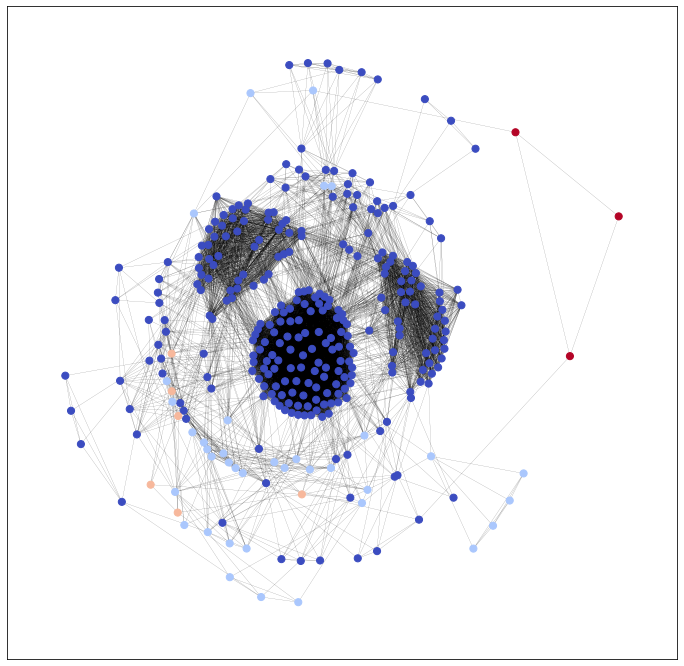

In [27]:
# %%writefile scripts/graph_run.py

import sys
sys.path.insert(0, '../')
import functions.graph_utilities as gu
import functions.node_classification as nc

import pandas as pd
from torch_geometric.transforms import RandomNodeSplit

# Import data
data = pd.read_csv("C:/Users\lukec\OneDrive - University of Cambridge\PhD\Data\Aggregate/US_2019.csv",
                   low_memory=False).dropna(subset='CO2e')

# Build graph
graph = gu.build(data, ['PRODUCT','SITE'], y_col='CO2e', bins=6, complete_only=True)

# Draw graph
gu.draw_pyg_graph(graph)

In [75]:
%%writefile functions/node_classification.py

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
import sklearn.metrics as skm
import matplotlib.pyplot as plt


class GCN(torch.nn.Module):
    """Graph Convolutional Network model"""
    def __init__(self, dataset, hidden_channels):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, len(dataset.y.unique()))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train(data, model, optimizer, criterion = torch.nn.CrossEntropyLoss()):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss, model, optimizer


def test(data, model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability
      return pred


def metrics(data, pred, type=False):
    y_true, y_pred = data.y[data.test_mask], pred[data.test_mask]
    metric_dict = {'confusion': skm.confusion_matrix(y_true, y_pred),
                   'overall_acc': skm.accuracy_score(y_true, y_pred),
                   'average_acc': skm.balanced_accuracy_score(y_true, y_pred),
                   'kappa': skm.cohen_kappa_score(y_true, y_pred),
                   'IoU': skm.jaccard_score(y_true, y_pred, average='weighted')}
    return dict(filter(lambda i:i[0] in type, metric_dict.items())) if type else metric_dict


def plot_confusion(conf_mat):
    fig, ax = plt.subplots(1,1,figsize=[6,6])
    ax.imshow(conf_mat, interpolation='nearest')
    classes = range(len(conf_mat))
    ax.set_xticks(range(len(classes))), ax.set_xticklabels(classes), ax.set_yticks(range(len(classes))), ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted Class',fontsize=12), ax.set_ylabel('True Class',fontsize=12)
    for i in range(len(classes)):
        for j in range(len(classes)): text = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="r")


def TSNE_visualize(h, color):
    """Define TSNE visualisation"""
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


def run(data, model, optimizer, verbose=True, confusion=True):
    for epoch in range(1, 100):
        loss, model, optimizer = train(data, model, optimizer)
        if verbose: print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    pred = test(data, model)
    scores = metrics(data,pred)
    print('Test Accuracy: {:.4f}'.format(scores['overall_acc']))
    if confusion: plot_confusion(scores['confusion'])

Overwriting functions/node_classification.py


Epoch: 001, Loss: 139.4330
Epoch: 002, Loss: 76.4124
Epoch: 003, Loss: 32.8968
Epoch: 004, Loss: 16.5507
Epoch: 005, Loss: 4.3013
Epoch: 006, Loss: 6.2482
Epoch: 007, Loss: 5.5278
Epoch: 008, Loss: 5.5788
Epoch: 009, Loss: 6.6754
Epoch: 010, Loss: 6.2909
Epoch: 011, Loss: 8.2076
Epoch: 012, Loss: 5.8277
Epoch: 013, Loss: 8.7454
Epoch: 014, Loss: 6.3496
Epoch: 015, Loss: 5.8306
Epoch: 016, Loss: 6.1004
Epoch: 017, Loss: 5.4640
Epoch: 018, Loss: 6.1684
Epoch: 019, Loss: 7.3921
Epoch: 020, Loss: 6.9045
Epoch: 021, Loss: 6.1842
Epoch: 022, Loss: 8.7956
Epoch: 023, Loss: 6.1600
Epoch: 024, Loss: 5.8795
Epoch: 025, Loss: 6.5273
Epoch: 026, Loss: 5.9377
Epoch: 027, Loss: 4.7953
Epoch: 028, Loss: 5.2618
Epoch: 029, Loss: 5.4150
Epoch: 030, Loss: 6.3622
Epoch: 031, Loss: 4.8052
Epoch: 032, Loss: 5.9202
Epoch: 033, Loss: 5.5185
Epoch: 034, Loss: 4.1312
Epoch: 035, Loss: 5.5712
Epoch: 036, Loss: 5.1144
Epoch: 037, Loss: 4.3459
Epoch: 038, Loss: 4.8997
Epoch: 039, Loss: 4.6390
Epoch: 040, Loss: 4.

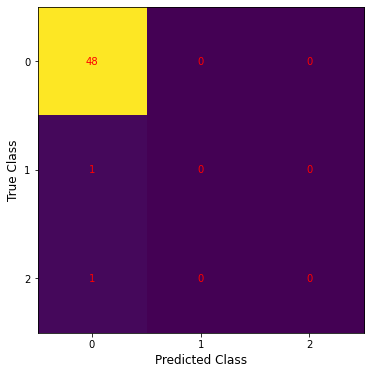

In [79]:
from importlib import reload
reload(nc), reload(gu)

# Build graph
graph = gu.build(data, ['PRODUCT','SITE'], y_col='CO2e', bins=5, complete_only=True)

"""Train & evaluate GCN model"""
input = graph
RandomNodeSplit('train_rest', num_val=10, num_test=50)(input)
GCN_model = nc.GCN(input, hidden_channels=30)
optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.01, weight_decay=5e-4)
nc.run(input, GCN_model, optimizer)

C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\emissions-tracking-conda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


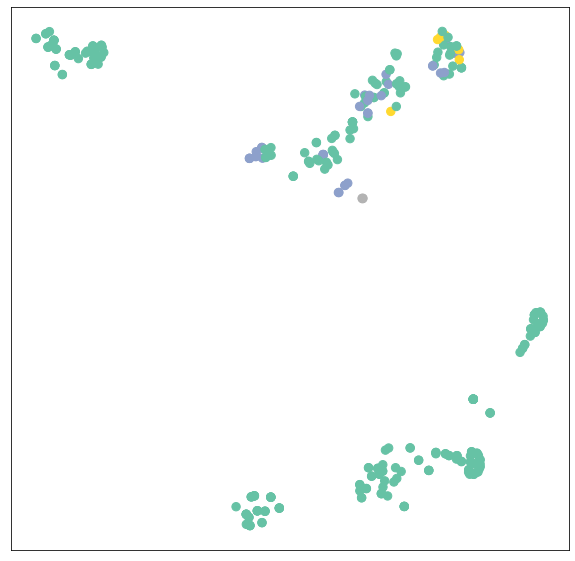

In [29]:
GCN_model.eval()

out = GCN_model(input.x, input.edge_index)
nc.TSNE_visualize(out, color=input.y)